# What features contributed to particular predictions


lets see which features contributed to particular predictions

See <a href="https://shap.readthedocs.io/en/latest/index.html">SHAP</a> documentation 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

## Install
see <a href="https://arxiv.org/pdf/2010.06734.pdf"> found that SHAP verse Treeinterpreter</a></strong><mark> found that SHAP took 60x longer than treeinterpreter to complete.</mark>  Concluded that treeinterpreter provided high quality results at a lower
 computational footprint.<br>
 But... SHAP is activly maintained and treeinterpreter may not be.
                        

In [2]:
# !conda install -c conda-forge shap -y

# Data

In [3]:
from sklearn.datasets import fetch_california_housing

calif_housing = fetch_california_housing()

for line in calif_housing.DESCR.split("\n")[5:22]:
    print(line)

calif_housing_df = pd.DataFrame(data=calif_housing.data, columns=calif_housing.feature_names)
calif_housing_df["Price($)"] = calif_housing.target

calif_housing_df.head()

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price($)
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
#get train/test split
from sklearn.model_selection import train_test_split
X, y = calif_housing.data, calif_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2,random_state=123)

# Model- Regression (SHAP also works with classification)

In [5]:
%%time
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=30, random_state=42)
clf.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 0 ns, total: 2.29 s
Wall time: 2.29 s


RandomForestRegressor(n_estimators=30, random_state=42)

# SHAP
random forests can be turned into a “white box”, such that each prediction is decomposed into a sum of contributions from each feature.<br>
![](./shap.png)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see <a href="https://github.com/slundberg/shap#citations">papers</a> for details and citations).<br>

<mark>One difference between SHAP and treeinterpreter is that SHAP works on any model, not just trees

Lets look at the SHAP values for the first few rows

In [6]:
rows=X_train[:100]

#lets see what the first n preds are
clf.predict(rows[:10])

array([2.60316667, 2.864067  , 1.77033333, 2.16126667, 1.28473333,
       1.89153333, 0.75456667, 1.24253333, 3.13476667, 1.47716667])

In [7]:
%%time
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(clf)
shap_values = explainer(rows)

CPU times: user 6.77 s, sys: 0 ns, total: 6.77 s
Wall time: 6.81 s


In [8]:
#the original value of each feature for row 0
rows[0]

array([   4.5694    ,   28.        ,    6.2195122 ,    1.0304878 ,
        504.        ,    3.07317073,   38.38      , -122.33      ])

In [12]:
#the shap values for row 0, 
#values are original features
#base value is average prediction on entire training set
# data= SHAPly values, or how much each feature contributed to result
shap_values[0]

.values =
array([ 0.3803642 ,  0.0681812 ,  0.04510107,  0.01679805,  0.02089477,
       -0.10904687, -0.34065463,  0.45283065])

.base_values =
array([2.06869821])

.data =
array([   4.5694    ,   28.        ,    6.2195122 ,    1.0304878 ,
        504.        ,    3.07317073,   38.38      , -122.33      ])

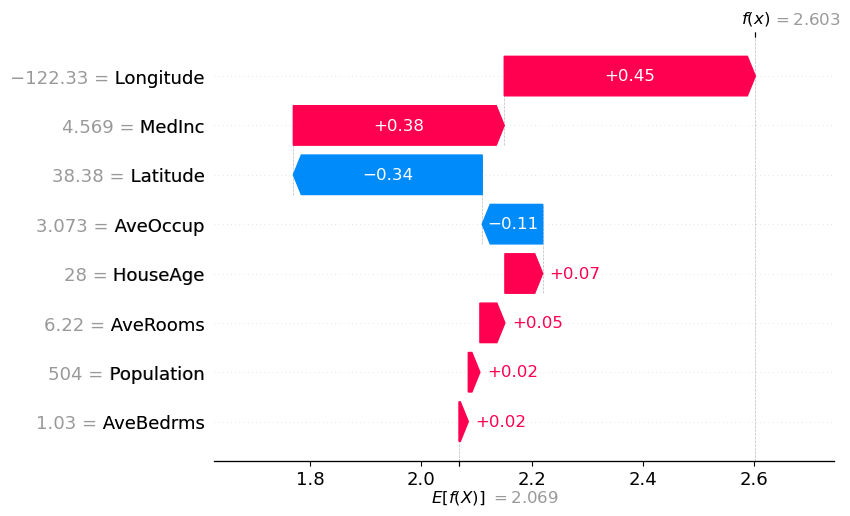

In [13]:
# SET UP THE WORKAROUND see https://github.com/slundberg/shap/issues/2255 as to why
class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = rows[i]
        self.feature_names = calif_housing.feature_names
        self.values = shap_values.values[i]
        
# visualize the first prediction's explanation
shap.waterfall_plot(helper_object(0), len(shap_values[0])) # plots the waterfall for the ith observation. As optional input give waterfall_plot the number of features, in order to draw them all. Since all observations have the same number of features, the index of the second argument does not need to be adjusted.


The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot

### What is E[f(x)]? It is the average prediction of your model on the entire X_train dataset (used as a baseline value by SHAP).

NOTE: see <a href="https://github.com/slundberg/shap/issues/318#issuecomment-437429986">shap explainer expected_value is different from model expected value:</a> for explanation of why this number differes slightly from SHAPs expected_value when using Random Forest.

Start from this value and determine what effect, positive or negative, each feature adds.

In [ ]:
#this is the average of all predictions on X_train
preds_all=clf.predict(X_train)
np.average(preds_all)

In [ ]:
explainer.expected_value

## What about if you want to see the effects that each feature has on many rows?

In [ ]:
#set the feature names
shap_values.feature_names=calif_housing.feature_names

In [ ]:
#you have to initialize javascript for the force plot to run
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, rows)

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[1])

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
# shap.dependence_plot(0, shap_values, X_test)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(helper_object(5), len(shap_values[0]), color=shap_values)